## **Predict Future Sales: 時系列を考慮した特徴量**
Final project for "How to win a data science competition" Coursera course<br>
https://www.kaggle.com/c/competitive-data-science-predict-future-sales/overview

#### **Data Preparation**

In [20]:
import pandas as pd
import numpy as np
import glob 
import os
import matplotlib.pyplot as plt

In [21]:
rawdata = {}
rawdata["item_cat"] = pd.read_csv(os.path.join("rawdata","item_categories.csv"),encoding="utf-8",index_col=1)
rawdata["items"] = pd.read_csv(os.path.join("rawdata","items.csv"),encoding="utf-8",index_col=1)
rawdata["sales_train"] = pd.read_csv(os.path.join("data","sales_train.csv"),encoding="utf-8",parse_dates=[0],index_col=0)
rawdata["shops"] = pd.read_csv(os.path.join("rawdata","shops.csv"),encoding="utf-8")
rawdata["test"] = pd.read_csv(os.path.join("rawdata","test.csv"),encoding="utf-8")

In [22]:
for key in rawdata.keys():
    df = rawdata[key]
    print("***",key,"***")
    print(df.head(3))
    print("[Nan Values]")
    print(df.isna().sum())
    print("---------------------")

*** item_cat ***
                       item_category_name
item_category_id                         
0                 PC - Гарнитуры/Наушники
1                        Аксессуары - PS2
2                        Аксессуары - PS3
[Nan Values]
item_category_name    0
dtype: int64
---------------------
*** items ***
                                                 item_name  item_category_id
item_id                                                                     
0                ! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.)         D                40
1        !ABBYY FineReader 12 Professional Edition Full...                76
2            ***В ЛУЧАХ СЛАВЫ   (UNV)                    D                40
[Nan Values]
item_name           0
item_category_id    0
dtype: int64
---------------------
*** sales_train ***
            date_block_num  shop_id  item_id  item_price  item_cnt_day
date                                                                  
2013-02-01               0       59    22154    

#### **簡易的な特徴量作成**
shop_id,item_id,年の情報を入れる. 目的変数は月の合計値とする

In [23]:
rawdata["train"] = rawdata["sales_train"].groupby(by=["date_block_num","shop_id","item_id"]).sum()[["item_cnt_day"]].reset_index()
rawdata["train"] = rawdata["train"].rename(columns={"item_cnt_day":"item_cnt_month"})
rawdata["test"]["date_block_num"] = 34
rawdata["test"]["item_cnt_month"] = np.nan

print("###### train ######")
print(rawdata["train"])
print("###### test ######")
print(rawdata["test"])

###### train ######
         date_block_num  shop_id  item_id  item_cnt_month
0                     0        0       32             6.0
1                     0        0       33             3.0
2                     0        0       35             1.0
3                     0        0       43             1.0
4                     0        0       51             2.0
...                 ...      ...      ...             ...
1609119              33       59    22087             6.0
1609120              33       59    22088             2.0
1609121              33       59    22091             1.0
1609122              33       59    22100             1.0
1609123              33       59    22102             1.0

[1609124 rows x 4 columns]
###### test ######
            ID  shop_id  item_id  date_block_num  item_cnt_month
0            0        5     5037              34             NaN
1            1        5     5320              34             NaN
2            2        5     5233          

### **ベースデータ作成**

In [24]:
# データ結合
rawdata["train"]["data_type"] = "train"
rawdata["test"]["data_type"] = "test"
data = pd.concat([rawdata["train"],rawdata["test"]],sort=False)

#### 付加情報を作成

In [39]:
# 時刻の情報
date_time = pd.DataFrame()
date_time["date_block_num"] = range(34)
date_time["date_time"] = pd.date_range(start="2013-01-01 00:00:00",freq="1M",periods=34)

In [37]:
# 価格の情報

#学習データ
train_mask = data["data_type"] == "train"
train_price = pd.DataFrame(data[train_mask][["shop_id","item_id","date_block_num"]])
tmp = rawdata["sales_train"].groupby(by=["shop_id","item_id","date_block_num"]).agg({"item_price":["min","max","mean","median"]})
tmp.columns = [col[0] + '-' + col[1] for col in tmp.columns.values]
train_price = pd.merge(train_price,tmp,on=["shop_id","item_id","date_block_num"],how="left")

# テストデータ
test_price = pd.DataFrame(data[~train_mask][["shop_id","item_id","date_block_num"]])
tmp = rawdata["sales_train"].groupby(by=["shop_id","item_id"]).agg({"item_price":["min","max","mean","median"]})
tmp.columns = [col[0] + '-' + col[1] for col in tmp.columns.values]
test_price = pd.merge(test_price,tmp,on=["shop_id","item_id"],how="left")
test_price["date_block_num"] = 34

# まとめる
price = pd.concat([train_price,test_price])

In [40]:
data = pd.merge(data,date_time,on="date_block_num",how="left")
data = pd.merge(data,price,on=["shop_id","item_id","date_block_num"],how="left")

#### **ラグ情報の付与**

In [41]:
def lag_feature(df, lags, col):
    tmp = df[['date_block_num','shop_id','item_id',col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)]
        shifted['date_block_num'] += i
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
    return df


data = lag_feature(data, [1,2,3,6,12], 'item_cnt_month')
data

,index,date_block_num,shop_id,item_id,item_cnt_month,data_type,ID,date_time_x,item_price - min,item_price - max,...,date_time_y,item_price-min,item_price-max,item_price-mean,item_price-median,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12
0,0,0,0,32,6.0,train,NaN,2013-01-31,221.0,221.0,...,2013-01-31,221.0,221.0,221.000000,221.0,NaN,NaN,NaN,NaN,NaN
1,1,0,0,33,3.0,train,NaN,2013-01-31,347.0,347.0,...,2013-01-31,347.0,347.0,347.000000,347.0,NaN,NaN,NaN,NaN,NaN
2,2,0,0,35,1.0,train,NaN,2013-01-31,247.0,247.0,...,2013-01-31,247.0,247.0,247.000000,247.0,NaN,NaN,NaN,NaN,NaN
3,3,0,0,43,1.0,train,NaN,2013-01-31,221.0,221.0,...,2013-01-31,221.0,221.0,221.000000,221.0,NaN,NaN,NaN,NaN,NaN
4,4,0,0,51,2.0,train,NaN,2013-01-31,127.0,130.0,...,2013-01-31,127.0,130.0,128.500000,128.5,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1823319,1823319,34,45,18454,NaN,test,214195.0,NaT,99.0,NaN,...,NaT,99.0,199.0,187.888889,199.0,1.0,NaN,NaN,NaN,NaN
1823320,1823320,34,45,16188,NaN,test,214196.0,NaT,NaN,NaN,...,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1823321,1823321,34,45,15757,NaN,test,214197.0,NaT,NaN,NaN,...,NaT,199.0,199.0,199.000000,199.0,NaN,NaN,NaN,NaN,NaN
1823322,1823322,34,45,19648,NaN,test,214198.0,NaT,NaN,NaN,...,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### **XGBRegressorによる回帰**

** target **
item_cnt_month

** features **
['shop_id', 'item_id', 'date_block_num', 'item_price-min', 'item_price-max', 'item_price-mean', 'item_price-median', 'item_cnt_month_lag_1', 'item_cnt_month_lag_2', 'item_cnt_month_lag_3', 'item_cnt_month_lag_6', 'item_cnt_month_lag_12']

train:
           index  date_block_num  shop_id  item_id  item_cnt_month data_type  \
0              0               0        0       32             6.0     train   
1              1               0        0       33             3.0     train   
2              2               0        0       35             1.0     train   
3              3               0        0       43             1.0     train   
4              4               0        0       51             2.0     train   
...          ...             ...      ...      ...             ...       ...   
1609119  1609119              33       59    22087             6.0     train   
1609120  1609120              33       59    22088             2.0    

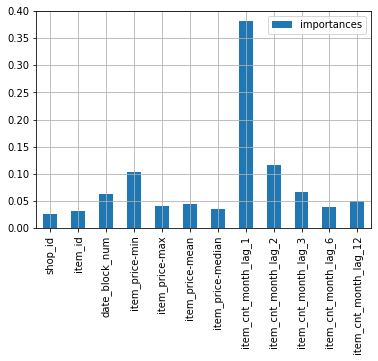

In [43]:
import xgboost as xgb

target = "item_cnt_month"
features = ['shop_id',
            'item_id', 
            'date_block_num', 
            #'item_cnt_day', 
            #'data_type',
            #'ID',
            #'date_time',
            'item_price-min',
            'item_price-max',
            'item_price-mean',
            'item_price-median',
            'item_cnt_month_lag_1',
            'item_cnt_month_lag_2',
            'item_cnt_month_lag_3',
            'item_cnt_month_lag_6',
            'item_cnt_month_lag_12']

print("** target **")
print(target)
print()
print("** features **")
print(features)
print()

mask = data["data_type"] == "train"
train = data[mask]
print("train:")
print(train)
trainX = train[features].values
trainY = train[target].values

reg = xgb.XGBRegressor(tree_method='gpu_hist')
reg.fit(trainX,trainY)


# importance の表示
importance = pd.DataFrame(columns=["importances"],
                          data=np.array([reg.feature_importances_]).T,
                          index=features)
importance.plot.bar()
plt.grid(True)
plt.show()

In [44]:
#predict
mask = data["data_type"] == "test"
testX = data[mask][features]
print(testX)
data.loc[mask,target] = reg.predict(testX.values)

         shop_id  item_id  date_block_num  item_price-min  item_price-max  \
1609124        5     5037              34           749.0          2599.0   
1609125        5     5320              34             NaN             NaN   
1609126        5     5233              34           599.0          1199.0   
1609127        5     5232              34           599.0           599.0   
1609128        5     5268              34             NaN             NaN   
...          ...      ...             ...             ...             ...   
1823319       45    18454              34            99.0           199.0   
1823320       45    16188              34             NaN             NaN   
1823321       45    15757              34           199.0           199.0   
1823322       45    19648              34             NaN             NaN   
1823323       45      969              34           549.0           549.0   

         item_price-mean  item_price-median  item_cnt_month_lag_1  \
160912

In [48]:
# submission
mysub = pd.read_csv(os.path.join("submission","sample_submission.csv"),index_col=0)
mysub.loc[data[mask]["ID"],"item_cnt_month"] = data[mask][target].values

In [49]:
mysub.to_csv(os.path.join("submission","XGBoost_ver2-範囲処理なし.csv"))
!kaggle competitions submit -c competitive-data-science-predict-future-sales -f submission/XGBoost_ver2-範囲処理なし.csv -m "Message"

Successfully submitted to Predict Future Sales



  0%|          | 0.00/5.28M [00:00<?, ?B/s]
  1%|1         | 80.0k/5.28M [00:00<00:06, 801kB/s]
 16%|#6        | 888k/5.28M [00:00<00:04, 985kB/s] 
 32%|###1      | 1.67M/5.28M [00:00<00:02, 1.34MB/s]
 37%|###7      | 1.97M/5.28M [00:01<00:04, 775kB/s] 
 42%|####2     | 2.22M/5.28M [00:01<00:04, 772kB/s]
 48%|####8     | 2.54M/5.28M [00:01<00:02, 1.00MB/s]
 63%|######3   | 3.34M/5.28M [00:01<00:01, 1.36MB/s]
 78%|#######8  | 4.12M/5.28M [00:02<00:00, 1.82MB/s]
 93%|#########3| 4.93M/5.28M [00:02<00:00, 2.38MB/s]
100%|##########| 5.28M/5.28M [00:05<00:00, 1.06MB/s]


In [50]:
mysub[mysub["item_cnt_month"] < 0] = 0
mysub[mysub["item_cnt_month"] > 20] = 20
mysub.to_csv(os.path.join("submission","XGBoost_ver2-範囲処理あり.csv"))
!kaggle competitions submit -c competitive-data-science-predict-future-sales -f submission/XGBoost_ver2-範囲処理あり.csv -m "Message"

Successfully submitted to Predict Future Sales



  0%|          | 0.00/4.87M [00:00<?, ?B/s]
  2%|1         | 96.0k/4.87M [00:00<00:05, 942kB/s]
 18%|#8        | 912k/4.87M [00:00<00:03, 1.13MB/s]
 30%|###       | 1.46M/4.87M [00:00<00:02, 1.48MB/s]
 34%|###4      | 1.68M/4.87M [00:00<00:02, 1.30MB/s]
 38%|###8      | 1.86M/4.87M [00:00<00:02, 1.36MB/s]
 42%|####1     | 2.03M/4.87M [00:03<00:15, 198kB/s] 
 46%|####6     | 2.26M/4.87M [00:04<00:10, 251kB/s]
 54%|#####3    | 2.62M/4.87M [00:04<00:06, 349kB/s]
 70%|######9   | 3.41M/4.87M [00:04<00:03, 490kB/s]
 86%|########6 | 4.20M/4.87M [00:04<00:01, 683kB/s]
100%|##########| 4.87M/4.87M [00:08<00:00, 600kB/s]
